## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/input/2023 교원그룹 AI 챌린지 예선.zip"

In [3]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader # Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.

from torchvision.models import resnet18
from torchvision import transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [4]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Train/Validation Split

In [6]:
df = pd.read_csv('./train.csv')
df

,id,img_path,label
0,TRAIN_00000,./train/TRAIN_00000.png,빨간색
1,TRAIN_00001,./train/TRAIN_00001.png,머
2,TRAIN_00002,./train/TRAIN_00002.png,차차
3,TRAIN_00003,./train/TRAIN_00003.png,써
4,TRAIN_00004,./train/TRAIN_00004.png,놓치다
...,...,...,...
76883,TRAIN_76883,./train/TRAIN_76883.png,회
76884,TRAIN_76884,./train/TRAIN_76884.png,겪다
76885,TRAIN_76885,./train/TRAIN_76885.png,벨트
76886,TRAIN_76886,./train/TRAIN_76886.png,톼


In [7]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]
train_v1

,id,img_path,label,len
1,TRAIN_00001,./train/TRAIN_00001.png,머,1
3,TRAIN_00003,./train/TRAIN_00003.png,써,1
7,TRAIN_00007,./train/TRAIN_00007.png,빈,1
10,TRAIN_00010,./train/TRAIN_00010.png,윷,1
27,TRAIN_00027,./train/TRAIN_00027.png,훵,1
...,...,...,...,...
76869,TRAIN_76869,./train/TRAIN_76869.png,틈,1
76872,TRAIN_76872,./train/TRAIN_76872.png,부,1
76878,TRAIN_76878,./train/TRAIN_76878.png,잔,1
76883,TRAIN_76883,./train/TRAIN_76883.png,회,1


In [8]:
# 제공된 학습데이터 중 2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.2, random_state=CFG['SEED'])
train_v2

,id,img_path,label,len
17983,TRAIN_17983,./train/TRAIN_17983.png,부족,2
30337,TRAIN_30337,./train/TRAIN_30337.png,넘어서다,4
44533,TRAIN_44533,./train/TRAIN_44533.png,손실,2
70677,TRAIN_70677,./train/TRAIN_70677.png,언덕,2
37259,TRAIN_37259,./train/TRAIN_37259.png,부르다,3
...,...,...,...,...
73347,TRAIN_73347,./train/TRAIN_73347.png,경기,2
59671,TRAIN_59671,./train/TRAIN_59671.png,혼잣말,3
29612,TRAIN_29612,./train/TRAIN_29612.png,계속,2
1286,TRAIN_01286,./train/TRAIN_01286.png,단계,2


In [9]:
# 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2])
train

,id,img_path,label,len
1,TRAIN_00001,./train/TRAIN_00001.png,머,1
3,TRAIN_00003,./train/TRAIN_00003.png,써,1
7,TRAIN_00007,./train/TRAIN_00007.png,빈,1
10,TRAIN_00010,./train/TRAIN_00010.png,윷,1
27,TRAIN_00027,./train/TRAIN_00027.png,훵,1
...,...,...,...,...
73347,TRAIN_73347,./train/TRAIN_73347.png,경기,2
59671,TRAIN_59671,./train/TRAIN_59671.png,혼잣말,3
29612,TRAIN_29612,./train/TRAIN_29612.png,계속,2
1286,TRAIN_01286,./train/TRAIN_01286.png,단계,2


In [10]:
print(len(train), len(val))

66251 10637


## Get Vocabulary

In [11]:
train_gt = [gt for gt in train['label']] # ['머', '써', '빈', '윷', '훵', ... , '손수']
train_gt = "".join(train_gt) # '머써빈윷훵저절..혼잣말계속단계손수'
# 학습 데이터로부터 단어 사전(Vocabulary) 구축
letters = sorted(list(set(list(train_gt)))) # ['가','각','간','갇','갈','갉', ... ,'힝']
print(len(letters)) # 단어사전 속의 1음절 개수

2349


In [12]:
vocabulary = ["-"] + letters # ['-', '가','각','간','갇','갈','갉', ... ,'힝']
print(len(vocabulary)) # 2350

2350


In [13]:
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)} # {0: '-', 1: '가', 2: '각', ... 2349: '힝'}
char2idx = {v:k for k,v in idx2char.items()} # {'-': 0, '가': 1,'각': 2, ...  '힝': 2349}

## CustomDataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True):
        self.img_path_list = img_path_list # 이미지 url
        self.label_list = label_list # 정답
        self.train_mode = train_mode # train or test
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        # RGB 3색
        image = Image.open(self.img_path_list[index]).convert('RGB')
        
        # 이미지 변환(Resize+정규화)
        if self.train_mode:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
            
        # 정답이 있으면 image, text 리턴, 없으면 image만 리턴
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])), # 64, 224
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def test_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),# 64, 224
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [15]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, True) # <__main__.CustomDataset at 0x7ff5f879abe0>
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS']) # <torch.utils.data.dataloader.DataLoader at 0x7ff5f879aee0># batch_size=256, num_workers=4
val_dataset = CustomDataset(val['img_path'].values, val['label'].values, False)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS']) # batch_size=256, num_workers=4

In [16]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([256, 3, 64, 224]) ('신비', '그나마', '씻기다', '쉴', '일반', '셋', '수입되다', '세', '달리다', '뜁', '선원', '추가', '대량', '예매하다', '콩', '쯩', '못', '사모님', '뱀', '호주머니', '젤', '벌', '불', '베개', '수도권', '회복되다', '날씨', '유산', '견해', '체조', '얘', '튀김', '삼계탕', '어려움', '세', '발자국', '터', '함께', '스타', '샛', '참여하다', '븐', '학생증', '신인', '신청', '양복', '추진하다', '집중하다', '구분되다', '기타', '지구', '꽐', '명예', '대륙', '천장', '신', '칡', '창조', '걋', '나무', '향', '여행사', '강', '흄', '출발', '전철', '꿈', '캠페인', '유산', '자극', '품', '대출', '관광버스', '내외', '법', '딱', '알리다', '먹이다', '왼발', '이제', '씁', '뒷골목', '만들다', '특정하다', '학교생활', '잘나다', '륵', '우유', '찜', '가늘다', '낮다', '적다', '척', '도', '이', '맛', '바탕', '끌다', '애쓰다', '이거', '어느덧', '주사', '겁', '늰', '빵', '곡', '바탕', '상대편', '옆', '헤', '중단', '회', '악', '농민', '긴급', '실은', '활용', '수십', '사흘', '실리다', '확대되다', '읍', '택하다', '화', '꼬마', '이해하다', '불편하다', '전문직', '멀리', '죽', '가다', '많아지다', '암', '일자', '이념', '수입되다', '팀', '돌다', '악몽', '간단하다', '불리다', '발휘하다', '미술관', '과학자', '정확하다', '턱', '큽', '텍스트', '신', '이곳저곳', '무용가', '무', '자동', '참석', '기술', '뛸', '뱅', '만일', '소풍', 

In [ ]:
image_batch

tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2

In [ ]:
image_batch[0][0]

tensor([[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        ...,
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]])

In [ ]:
text_batch

('신비',
 '그나마',
 '씻기다',
 '쉴',
 '일반',
 '셋',
 '수입되다',
 '세',
 '달리다',
 '뜁',
 '선원',
 '추가',
 '대량',
 '예매하다',
 '콩',
 '쯩',
 '못',
 '사모님',
 '뱀',
 '호주머니',
 '젤',
 '벌',
 '불',
 '베개',
 '수도권',
 '회복되다',
 '날씨',
 '유산',
 '견해',
 '체조',
 '얘',
 '튀김',
 '삼계탕',
 '어려움',
 '세',
 '발자국',
 '터',
 '함께',
 '스타',
 '샛',
 '참여하다',
 '븐',
 '학생증',
 '신인',
 '신청',
 '양복',
 '추진하다',
 '집중하다',
 '구분되다',
 '기타',
 '지구',
 '꽐',
 '명예',
 '대륙',
 '천장',
 '신',
 '칡',
 '창조',
 '걋',
 '나무',
 '향',
 '여행사',
 '강',
 '흄',
 '출발',
 '전철',
 '꿈',
 '캠페인',
 '유산',
 '자극',
 '품',
 '대출',
 '관광버스',
 '내외',
 '법',
 '딱',
 '알리다',
 '먹이다',
 '왼발',
 '이제',
 '씁',
 '뒷골목',
 '만들다',
 '특정하다',
 '학교생활',
 '잘나다',
 '륵',
 '우유',
 '찜',
 '가늘다',
 '낮다',
 '적다',
 '척',
 '도',
 '이',
 '맛',
 '바탕',
 '끌다',
 '애쓰다',
 '이거',
 '어느덧',
 '주사',
 '겁',
 '늰',
 '빵',
 '곡',
 '바탕',
 '상대편',
 '옆',
 '헤',
 '중단',
 '회',
 '악',
 '농민',
 '긴급',
 '실은',
 '활용',
 '수십',
 '사흘',
 '실리다',
 '확대되다',
 '읍',
 '택하다',
 '화',
 '꼬마',
 '이해하다',
 '불편하다',
 '전문직',
 '멀리',
 '죽',
 '가다',
 '많아지다',
 '암',
 '일자',
 '이념',
 '수입되다',
 '팀',
 '돌다',
 '악몽',
 '간단하다',
 '불리다',
 '

In [ ]:
len(text_batch)

256

## Model Define

In [ ]:
resnet = resnet18(pretrained=True)
# CNN Feature Extract
resnet_modules = list(resnet.children())[:-3]
resnet_modules

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
nn.Sequential(
            *resnet_modules,
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

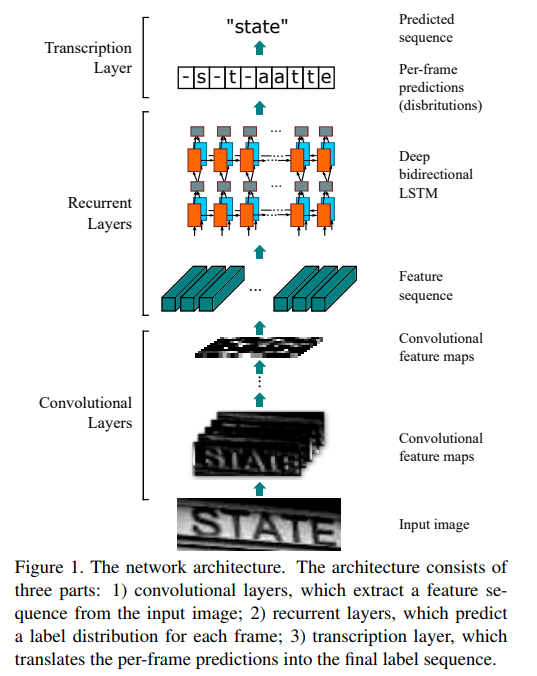

In [ ]:
image_batch.shape

torch.Size([256, 3, 64, 224])

In [ ]:
# https://tw0226.tistory.com/90
class RecognitionModel(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256): # num_chars=2350
        super(RecognitionModel, self).__init__()
        self.num_chars = num_chars # 2350
        self.rnn_hidden_size = rnn_hidden_size # 256
        
        # 1. CNN
        # CNN Backbone = 사전학습된 resnet18 활용 https://arxiv.org/abs/1512.03385
        resnet = resnet18(pretrained=True)
        # CNN Feature Extract -> resnet18 + CNN
        resnet_modules = list(resnet.children())[:-3]
        self.feature_extract = nn.Sequential(*resnet_modules,
                                              nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
                                              nn.BatchNorm2d(256),
                                              nn.ReLU(inplace=True))
        self.linear1 = nn.Linear(1024, rnn_hidden_size) # (1024, 256)
        
        # 2. RNN
        self.rnn = nn.RNN(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars) # 512, 2350
        
    def forward(self, x): # x=image_batch
        # 1. CNN
        x = self.feature_extract(x) # [batch_size, channels, height, width] # [256, 256, 4, 11]
        # 2. RNN input화
        # 먼저 reshape를 통해 width 특징은 유지한 채 RNN의 채널 개수는 width * channel 개수로 만들었다.
        # 이 때, CNN의 height 부분의 공간적 특징들이 섞이는 것을 확인 할 수 있었다.
        # CNN output : B x W x H X C -> RNN_input : B x W x C_new1(= H x C)
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height] # [256, 11, 256, 4]
        batch_size = x.size(0) # 256
        T = x.size(1) # width==11
        x = x.view(batch_size, T, -1) # [batch_size==256, T==width==11, num_features==channels*height==256*4==1024]
        x = self.linear1(x) # [256, 11, 256]
        
        # 2. RNN
        x, hidden = self.rnn(x) # [256, 11, 512], [2, 256, 256]
        
        output = self.linear2(x) # [256, 11, 2350]
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features][11, 256, 2350]
        return output

In [ ]:
model1 = RecognitionModel()
model2 = model1(image_batch)
model2.shape

torch.Size([11, 256, 2350])

## Define CTC Loss

In [ ]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [ ]:
def encode_text_batch(text_batch):
    # 텍스트 -> 텍스트 길이추출 + Tensor화
    text_batch_targets_lens = [len(text) for text in text_batch] # [2,3,..,3]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens) # tensor([2,3,..,3], dtype=torch.int32)
    
    # 텍스트 -> 텍스트 인덱스추출 + Tensor화
    text_batch_concat = "".join(text_batch) # '신비그나...'
    text_batch_targets = [char2idx[c] for c in text_batch_concat] # [1258, 1020, 149, 292,.. ]
    text_batch_targets = torch.IntTensor(text_batch_targets) # tensor([1258, 1020, 149, 292,.. ], dtype=torch.int32)
    return text_batch_targets, text_batch_targets_lens # 텍스트 인덱스, 텍스트 길이

In [ ]:
def compute_loss(text_batch, text_batch_logits): # 정답_batch, 이미지_batch
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) #torch.Size([11, 256, 2350]) [T, batch_size, num_classes]  # 소프트맥스(softmax)는 입력값(k차원의 벡터)을 0에서 1 사이의 값으로 정규화해 k개의 각 클래스에 대한 확률을 추정하는 함수로, 이 때 출력값들의 총합은 1이 된다.
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), # width
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens) # [T, batch_size, num_classes], 텍스트 인덱스, [batch_size], 텍스트 길이
    return loss # tensor(50.7064, grad_fn=<MeanBackward0>)

In [ ]:
image_batch.shape

torch.Size([256, 3, 64, 224])

In [ ]:
text_batch_logps1 = F.softmax(model2, 2)
text_batch_logps1

tensor([[[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0005],
         [0.0003, 0.0005, 0.0004,  ..., 0.0005, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0005, 0.0004],
         ...,
         [0.0004, 0.0004, 0.0004,  ..., 0.0005, 0.0004, 0.0005],
         [0.0004, 0.0004, 0.0004,  ..., 0.0005, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0003,  ..., 0.0005, 0.0004, 0.0005]],

        [[0.0004, 0.0004, 0.0003,  ..., 0.0004, 0.0004, 0.0005],
         [0.0004, 0.0004, 0.0003,  ..., 0.0005, 0.0004, 0.0005],
         [0.0005, 0.0003, 0.0003,  ..., 0.0004, 0.0004, 0.0006],
         ...,
         [0.0004, 0.0004, 0.0003,  ..., 0.0004, 0.0004, 0.0005],
         [0.0006, 0.0004, 0.0003,  ..., 0.0004, 0.0004, 0.0005],
         [0.0005, 0.0003, 0.0003,  ..., 0.0004, 0.0003, 0.0005]],

        [[0.0004, 0.0003, 0.0004,  ..., 0.0004, 0.0004, 0.0005],
         [0.0004, 0.0005, 0.0004,  ..., 0.0005, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004,  ..., 0.0005, 0.0004, 0.

In [ ]:
text_batch_logps = F.log_softmax(model2, 2) # ln(0.0004)=-7.9363
text_batch_logps

tensor([[[-7.9363, -7.8244, -7.7554,  ..., -7.7360, -7.8271, -7.6569],
         [-8.0021, -7.6042, -7.8856,  ..., -7.6284, -7.8096, -7.8181],
         [-7.8693, -7.8999, -7.8672,  ..., -7.7664, -7.6861, -7.8288],
         ...,
         [-7.7856, -7.9516, -7.8021,  ..., -7.7025, -7.9098, -7.6217],
         [-7.8165, -7.7263, -7.9319,  ..., -7.7041, -7.7664, -7.8436],
         [-7.8706, -7.9163, -7.9627,  ..., -7.6945, -7.8284, -7.6149]],

        [[-7.9106, -7.9282, -8.0639,  ..., -7.7422, -7.8663, -7.5122],
         [-7.8942, -7.7544, -8.1935,  ..., -7.5806, -7.8884, -7.5549],
         [-7.6741, -8.1258, -8.0612,  ..., -7.7536, -7.8869, -7.4966],
         ...,
         [-7.7822, -7.8761, -7.9771,  ..., -7.9051, -7.8728, -7.5640],
         [-7.4856, -7.8750, -8.0915,  ..., -7.8007, -7.9122, -7.6380],
         [-7.6403, -8.0550, -8.0930,  ..., -7.7174, -7.9578, -7.6085]],

        [[-7.9452, -8.0375, -7.8796,  ..., -7.7250, -7.8705, -7.5088],
         [-7.8183, -7.6942, -7.8740,  ..., -7

In [ ]:
text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                    fill_value=text_batch_logps.size(0), 
                                    dtype=torch.int32).to(device) # [batch_size] 
text_batch_logps_lens

tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 

## Train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    best_loss = 999999
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+1): # 20
        model.train()
        train_loss = []
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        _val_loss = validation(model, val_loader, device)
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        
        if scheduler is not None: # ReduceLROnPlateau
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model
    
    return best_model

## Validation

In [ ]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

## Run!!

In [ ]:
model = RecognitionModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [6.94041] Val CTC Loss : [5.04018]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [2] Train CTC Loss : [4.56408] Val CTC Loss : [2.54862]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [3] Train CTC Loss : [2.48266] Val CTC Loss : [1.29316]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [4] Train CTC Loss : [1.37390] Val CTC Loss : [0.76235]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [5] Train CTC Loss : [0.84056] Val CTC Loss : [0.64211]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [6] Train CTC Loss : [0.54400] Val CTC Loss : [0.39389]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [7] Train CTC Loss : [0.36146] Val CTC Loss : [0.35304]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [8] Train CTC Loss : [0.25655] Val CTC Loss : [0.32541]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [9] Train CTC Loss : [0.18155] Val CTC Loss : [0.27853]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [10] Train CTC Loss : [0.15152] Val CTC Loss : [0.32127]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [11] Train CTC Loss : [0.13637] Val CTC Loss : [0.26384]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [12] Train CTC Loss : [0.09217] Val CTC Loss : [0.24132]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [13] Train CTC Loss : [0.09779] Val CTC Loss : [0.28933]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [14] Train CTC Loss : [0.09008] Val CTC Loss : [0.30065]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.10133] Val CTC Loss : [0.27717]
Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [16] Train CTC Loss : [0.02921] Val CTC Loss : [0.15112]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [17] Train CTC Loss : [0.00693] Val CTC Loss : [0.14224]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [18] Train CTC Loss : [0.00403] Val CTC Loss : [0.13796]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [19] Train CTC Loss : [0.00312] Val CTC Loss : [0.13830]


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch : [20] Train CTC Loss : [0.00278] Val CTC Loss : [0.14017]


## Inference

In [ ]:
test = pd.read_csv('./test.csv')

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, False)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

In [ ]:
text_batch_tokens = F.softmax(model2, 2).argmax(2) # [T, batch_size]
text_batch_tokens = text_batch_tokens.numpy().T
text_batch_tokens.shape # torch.Size([11, 256])

(256, 11)

In [ ]:
for text_tokens in text_batch_tokens:
  print(text_tokens)

In [ ]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]torch.Size([11, 256])
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T](256, 11)

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens: # [1630 1426  188 1586 1162  219  501  617 1524 1573 1524], ...
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    return preds

In [ ]:
predictions = inference(infer_model, test_loader, device)

  0%|          | 0/290 [00:00<?, ?it/s]

## Submission

In [ ]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [ ]:
submit.to_csv('./submission.csv', index=False)